<a href="https://colab.research.google.com/github/Justsecret123/One-Piece-Image-Classifier/blob/master/Model_with_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import PIL
import IPython

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

import pathlib 
import zipfile

In [2]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 102kB 12.1MB/s 


# Files

## Dataset download

In [3]:
data_path = 'drive/My Drive/Data.zip'
zip_ref = zipfile.ZipFile(data_path,'r')
zip_ref.extractall('/tmp/')

In [4]:
data_dir = pathlib.PosixPath('/tmp/Data')

## Images count

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.jpeg'))) 
print(image_count)

1923


# Display some images

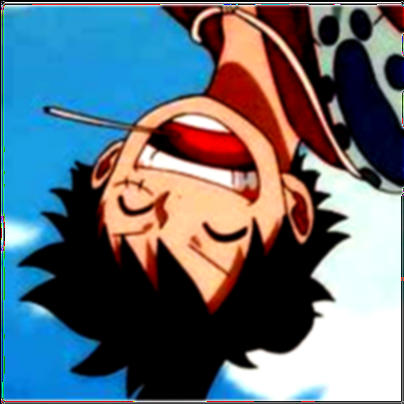

In [6]:
Luffy = list(data_dir.glob('Luffy/*'))
PIL.Image.open(str(Luffy[0]))

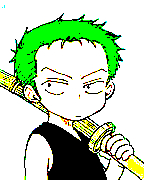

In [7]:
Zoro = list(data_dir.glob('Zoro/*'))
PIL.Image.open(str(Zoro[0]))

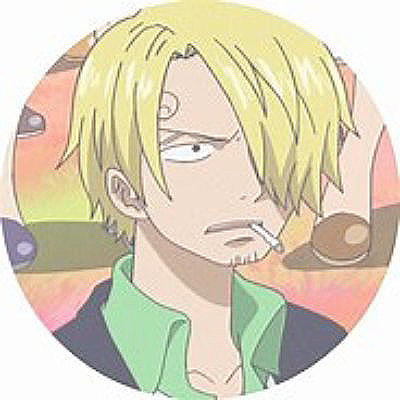

In [8]:
Sanji = list(data_dir.glob('Sanji/*'))
PIL.Image.open(str(Sanji[0]))

# Model builder

## Some parameters 

In [9]:
import random

In [10]:
random.seed()
seed = random.randint(0,100)

In [11]:
batch_size = 5
width = 180
height = 180

## Training dataset definition

In [12]:
train_dataset = preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(height,width),
    batch_size=batch_size
)

Found 1923 files belonging to 3 classes.
Using 1539 files for training.


In [13]:
classes_count = 3
class_names = train_dataset.class_names
print(class_names)

['Luffy', 'Sanji', 'Zoro']


## Validation dataset definition

In [14]:
val_dataset = preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(height, width),
    batch_size=batch_size
)

Found 1923 files belonging to 3 classes.
Using 384 files for validation.


# Data augmentation

In [15]:
data_augmentation = Sequential([
                                tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(height,width,3)),
                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                tf.keras.layers.experimental.preprocessing.RandomZoom(0.2), 
                    ])

# Model builder

## Description

*   3 Convolutional layers followed by a batch normalization layer, then a MaxPooling layer followed by a batch normalization layer  
*   A flatten layer 
*   A dense layer which number of units will be decided by the hyper parameters
*   And a dense layer which represents the final output 

Based on Sergey Ioffe and Christian Szegedy "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift" research paper, there is no need to add a dropout layer since we've used a batch normalization layer. 



*Note: when making predictions, we will apply a sigmoid to the return array to obtain the probability of the image belonging to each class*

*Additional notes: reducing the number of layers : less validation and training set accuracy*





In [16]:
def model_builder(hp):
  
   hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
   hp_learning_rate = hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

   model = Sequential()

   model.add(layers.Conv2D( filters=15, kernel_size=3, activation='relu'))
   model.add(layers.BatchNormalization()) 
   model.add(layers.MaxPool2D())
   model.add(layers.BatchNormalization())
   model.add(layers.Conv2D( filters=30, kernel_size=3, activation='relu'))
   model.add(layers.MaxPool2D())
   model.add(layers.BatchNormalization())
   model.add(layers.Conv2D( filters=60, kernel_size=3, activation='relu'))
   model.add(layers.MaxPool2D())
   model.add(layers.BatchNormalization())
   model.add(layers.Flatten())
   model.add(layers.Dense( units=hp_units, activation='relu', kernel_regularizer=regularizers.L2(l2=0.001)))
   model.add(layers.BatchNormalization())
   model.add(layers.Dense( classes_count, activation='softmax' ))

   model.compile(
       optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
       loss='sparse_categorical_crossentropy', 
       metrics=['accuracy']
  )
   
   return model

# Hypertuning 

## Callback function : *early stopping*

The validation loss will be the monitored parameter

In [17]:
stop_early = callbacks.EarlyStopping(monitor="val_loss", patience=5)

## Tuner

In [18]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3
)

In [19]:
tuner.search(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[stop_early]
)

Trial 30 Complete [00h 01m 08s]
val_accuracy: 0.8723958134651184

Best val_accuracy So Far: 0.890625
Total elapsed time: 00h 14m 26s
INFO:tensorflow:Oracle triggered exit


## Get the optimal parameters

In [20]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Model fit

In [21]:
model = tuner.hypermodel.build(best_hps)

### Use early stopping to stop the training process if the validation accuracy stops increasing after 4 epochs, and restore the weights which minimize the validation accuracy

In [22]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode ="max", verbose=2, restore_best_weights=True)

In [25]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=1, 
    callbacks = [stop_early]
)

Epoch 1/20
308/308 [==============================] - 6s 18ms/step - loss: 1.5545 - accuracy: 0.8330 - val_loss: 1.4194 - val_accuracy: 0.8880
Epoch 2/20
308/308 [==============================] - 5s 15ms/step - loss: 1.3897 - accuracy: 0.8661 - val_loss: 1.5198 - val_accuracy: 0.8177
Epoch 3/20
308/308 [==============================] - 5s 15ms/step - loss: 1.6401 - accuracy: 0.8415 - val_loss: 1.5383 - val_accuracy: 0.8932
Epoch 4/20
308/308 [==============================] - 5s 15ms/step - loss: 1.5485 - accuracy: 0.8609 - val_loss: 2.0625 - val_accuracy: 0.6536
Epoch 5/20
308/308 [==============================] - 5s 15ms/step - loss: 1.6616 - accuracy: 0.8200 - val_loss: 1.7034 - val_accuracy: 0.8229
Epoch 6/20
308/308 [==============================] - 5s 15ms/step - loss: 1.5728 - accuracy: 0.8454 - val_loss: 1.3502 - val_accuracy: 0.9141
Epoch 7/20
308/308 [==============================] - 5s 17ms/step - loss: 1.3658 - accuracy: 0.8837 - val_loss: 1.4725 - val_accuracy: 0.8333

# Model summary 

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 15)      420       
_________________________________________________________________
batch_normalization (BatchNo (None, 178, 178, 15)      60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 15)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 89, 89, 15)        60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 30)        4080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 30)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 43, 43, 30)        1

# Predictions

In [29]:
from google.colab import files
from keras.preprocessing import image

In [30]:
class_names = train_dataset.class_names
class_names

['Luffy', 'Sanji', 'Zoro']

In [31]:
def prediction(): 
  for filename in uploaded.keys():

    path = "/content/" + filename
    im = image.load_img(path,target_size=(180,180))
    
    inputs = image.img_to_array(im)

    inputs = np.vstack([inputs])

    inputs = tf.expand_dims(inputs,axis=0) #Creates a batch

    
    predictions = model.predict(inputs) #Make a prediction based on input values

    score = tf.nn.sigmoid(predictions[0]) #We use predictions[0] since predictions is a [[classes_count]] shape vector. 
                                          #(Could've used np.squeeze(predictions) instead)
    #Sigmoid will return the probability of the image belonging to each class.
    #Rather than a probability distribution, it is a set of probabilities.
    #Each label has its own probability, which do not depends on another label's probability.
    #Since we can have more than one character in the image, a sigmoid fits better than softmax which is a probability distribution. 
    #In our case, { P(X=Luffy) = score[0]
    #               P(X=Sanji) = score[1]
    #               P(X=Zoro) = score[2]
    #               P(X=Unknown) = score[3]
    #             } 

    print("Image: ", path)
    for i in range (len(score)):
      print("\nProbability of being " + class_names[i] + \
              ": ", 100*score[i].numpy() , "%")

    #print(predictions)

    object_score = np.max(score)  #np.argmax(score) :  returns the index with the highest score 
    object_class = class_names[np.argmax(score)]  #np.max(score) returns the highest probability of our input belonging to one of our classes
    

    plt.figure()
    plt.title("This image most likely belongs to " +str(object_class)+ \
              " category with a " + str(object_score) + " score.\n\n")
    
    plt.imshow(im)


    print("This image most likely belongs to " +str(object_class)+ \
          " category with a " + str(object_score) + " score. \n\n"
    )

In [35]:
uploaded = files.upload() 

Saving Sanji.jpg to Sanji (1).jpg


Image:  /content/Sanji.jpg

Probability of being Luffy:  50.01600384712219 %

Probability of being Sanji:  72.67141938209534 %

Probability of being Zoro:  50.533586740493774 %
This image most likely belongs to Sanji category with a 0.7267142 score. 




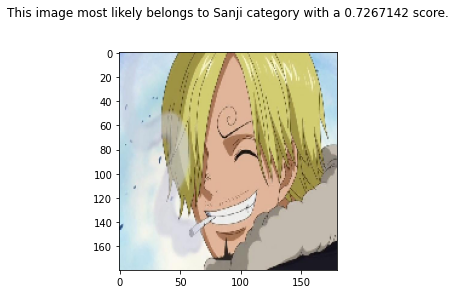

In [36]:
prediction()

In [28]:
model.save('drive/My Drive/Object_Detector_Model_KerasTuner_10epochs_Batch_Norm')

INFO:tensorflow:Assets written to: drive/My Drive/Object_Detector_Model_KerasTuner_10epochs_Batch_Norm/assets


In [27]:
model.evaluate(x=val_dataset, return_dict=True)

77/77 [==============================] - 1s 9ms/step - loss: 1.2913 - accuracy: 0.9297


{'accuracy': 0.9296875, 'loss': 1.2913269996643066}